In [1]:
import numpy as np
import pandas as pd
import random
import torch
import dgl
import os
import sys

# 현재 파일의 상위 디렉토리를 sys.path에 추가
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

c:\Programming\Anaconda\envs\chem\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 폰트 설정
import matplotlib as mpl
import matplotlib.font_manager as fm

font_path = r"C:\Windows\Fonts\malgun.ttf"  
font_prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# 재현성 난수 고정
def SET_SEED():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    dgl.random.seed(SEED)

    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 100
SET_SEED()

In [3]:
dataset = 'retry_logp' # freesolv / esol / molproperty_vd / lipo
save_dir = r'..\results_figure'

In [4]:
df = pd.read_csv(r'..\datasets\\' + dataset + '.csv')
smiles_list = df['smiles'].tolist()

# target 정의
target = df.iloc[:,-1]

print(smiles_list[:5])
print(target[:5])

['C=O', 'CNN', 'C(=O)O', 'CCl', 'CN']
0    0.35
1   -1.05
2   -0.54
3    0.91
4   -0.57
Name: LogP, dtype: float64


In [6]:
# 상황분류
df_class = pd.read_excel(r'C:\Users\linde\OneDrive\Desktop\3. 연구\2. 위해기체\6. 데이터셋\타겟 물질 60종_상황 분류.xlsx', skiprows=1).drop(columns = ['Unnamed: 0'])
df_122 = pd.read_excel(r'C:\Users\linde\OneDrive\Desktop\3. 연구\2. 위해기체\6. 데이터셋\smiles_122.xlsx')

class_dict = df_class.set_index('물질명')['구분1'].to_dict()
df_122['class'] = df_122['Name'].map(class_dict)
class_dict2 = df_122.set_index('SMILES')['class'].to_dict()
df['class'] = df['smiles'].map(class_dict2)
df['class'].count()

36

In [75]:
# for i in range(len(df_122['SMILES'].unique())):
#     idx = 0
#     print(df_122['SMILES'].unique()[i])
#     idx += 1

In [5]:
from utils.utils import MolecularFeatureExtractor
# 분자 특성 추출 및 데이터프레임 정의
extractor = MolecularFeatureExtractor()
df_all_features = extractor.extract_molecular_features(smiles_list)

df_all_features['target'] = target
df_all_features

num_all_features = df_all_features.shape[1] - 1 
print("초기 변수 개수:", num_all_features)

# na handling
# NA 확인
df_all_features[df_all_features.isna().any(axis = 1)] # 행방향

# 결측치가 포함된 feature 개수
print('결측치가 포함된 열 개수:', df_all_features.isna().any(axis = 0).sum(), '\n')
print(df_all_features.isna().any(axis = 0))

print('결측치가 포함된 행 개수:', df_all_features.isna().any(axis = 1).sum(), '\n')
print(df_all_features.isna().any(axis = 1))

df_removed_features = df_all_features.dropna()

# 결측치가 포함된 feature 제거
# df_removed_features = df_all_features.dropna(axis = 1)
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features)

# 결측치가 제거된 data frame
df_removed_features

# 결측치가 포함된 feature 개수
print('결측치가 포함된 열 개수:', df_removed_features.isna().any(axis = 0).sum(), '\n')
print(df_removed_features.isna().any(axis = 0))

print('결측치가 포함된 행 개수:', df_removed_features.isna().any(axis = 1).sum(), '\n')
print(df_removed_features.isna().any(axis = 1))



# nunique == 1 인 경우는 제
unique_columns = list(df_removed_features.loc[:, df_removed_features.nunique() == 1].columns)
print('nunique == 1인 feature : \n', unique_columns, '\n')

# nunique == 1인 feature 제거
#df_removed_features.drop(columns = unique_columns, inplace = True)
df_removed_features = df_removed_features.drop(columns = unique_columns).copy()

num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)


# 너무 낮은 vairnace를 가지는 경
low_variances = sorted(df_removed_features.var())
low_variances[:10]

columns_low_variances = []

for i in low_variances:
    if i < 0.001:
        column = df_removed_features.loc[:, df_removed_features.var() == i].columns
        columns_low_variances.append(column)
columns_low_variances = [item for index in columns_low_variances for item in index]

# 2. 중복 제거 및 유니크 값 추출
columns_low_variances = list(set(columns_low_variances))
print(columns_low_variances)

# 낮은 분산의 변수 제거
df_removed_features = df_removed_features.drop(columns = columns_low_variances).reset_index(drop=True).copy()
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)

df_removed_features

초기 변수 개수: 208
결측치가 포함된 열 개수: 12 

MaxEStateIndex       False
MinEStateIndex       False
MaxAbsEStateIndex    False
MinAbsEStateIndex    False
qed                  False
                     ...  
fr_thiocyan          False
fr_thiophene         False
fr_unbrch_alkane     False
fr_urea              False
target               False
Length: 209, dtype: bool
결측치가 포함된 행 개수: 4 

0     False
1     False
2     False
3     False
4     False
      ...  
65    False
66    False
67    False
68    False
69    False
Length: 70, dtype: bool
제거 후 남은 feature 개수: 208
결측치가 포함된 열 개수: 0 

MaxEStateIndex       False
MinEStateIndex       False
MaxAbsEStateIndex    False
MinAbsEStateIndex    False
qed                  False
                     ...  
fr_thiocyan          False
fr_thiophene         False
fr_unbrch_alkane     False
fr_urea              False
target               False
Length: 209, dtype: bool
결측치가 포함된 행 개수: 0 

0     False
1     False
2     False
3     False
4     False
      ...  
65    False
6

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_sulfide,fr_unbrch_alkane,target
0,8.000000,2.000000,8.000000,2.000000,0.360624,30.026,28.010,30.010565,12,0,...,0,0,0,0,0,0,0,0,0,0.35
1,4.597222,1.652778,4.597222,1.652778,0.273315,46.073,40.025,46.053098,20,0,...,0,0,0,0,0,0,0,0,0,-1.05
2,8.361111,-0.250000,8.361111,0.250000,0.380161,46.025,44.009,46.005479,18,0,...,0,0,0,0,0,0,0,0,0,-0.54
3,4.638889,1.472222,4.638889,1.472222,0.357363,50.488,47.464,49.992328,14,0,...,0,0,0,0,0,0,0,0,0,0.91
4,4.500000,1.500000,4.500000,1.500000,0.384658,31.058,26.018,31.042199,14,0,...,0,0,0,0,0,0,0,0,0,-0.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,1.500000,1.500000,1.500000,1.500000,0.422316,84.162,72.066,84.093900,36,0,...,0,0,0,0,0,0,0,0,0,3.44
62,10.506944,-2.654321,10.506944,1.351466,0.516867,124.076,115.004,124.028931,44,0,...,0,0,0,0,0,0,0,0,0,-0.61
63,10.524469,-0.115102,10.524469,0.115102,0.595026,151.165,142.093,151.063329,58,0,...,0,0,0,0,0,1,1,0,0,0.46
64,10.611948,-1.114028,10.611948,0.016019,0.550122,180.159,172.095,180.042259,68,0,...,0,0,0,0,1,0,0,0,0,1.18


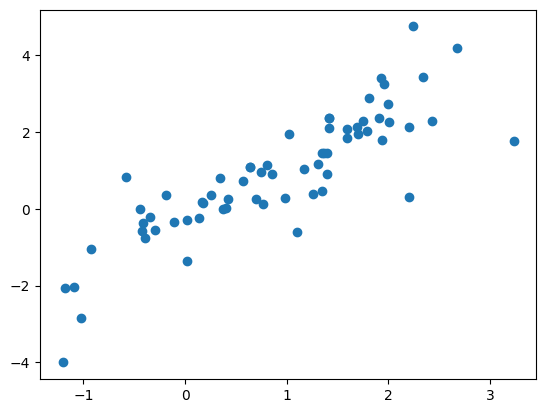

In [9]:
df_removed_features[['MolWt','target']]
import matplotlib.pyplot as plt

plt.scatter(x = df_removed_features['MolLogP'], y = df_removed_features['target'])
# plt.scatter(x = df_removed_features['NumValenceElectrons'], y = df_removed_features['target'])
plt.show()


# tSNE & PCA

In [77]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [78]:
# target split

# 4등분 / 사분위수 기준으로
Q1, Q2, Q3 = np.percentile(target, [25, 50, 75])
# Q2 = np.percentile(target, 50)
# Q3 = np.percentile(target, 75)
idx_Q1 = np.where(target < Q1)[0]
idx_Q2 = np.where((target >= Q1) & (target < Q2))[0]
idx_Q3 = np.where((target >= Q2) & (target < Q3))[0]
idx_Q4 = np.where(target >= Q3)[0]

# 1/3
med1 = np.percentile(target, 33)
med2 = np.percentile(target, 66)
idx_med4 = np.where(target < med1)[0]
idx_med5 = np.where((target >= med1) & (target < med2))[0]
idx_med6 = np.where(target >= med2)[0]

# 중앙값
med = np.percentile(target, 50)
idx_med1 = np.where(target < med)[0]
idx_med2 = np.where(target >= med)[0]

In [79]:
X = np.array(df_removed_features.drop(columns = ['target']))
X.shape

(94, 159)

In [80]:
target = df_removed_features.iloc[:,-1]
idx = target.index
test = df.loc[idx, :]
test
# test = df.loc[idx[mask]].reset_index(drop=True)
# test

,smiles,vapor density,class
0,C=O,1.04,NaN
1,CNN,1.60,NaN
2,C(=O)O,1.60,NaN
3,CCl,1.80,NaN
4,CN,1.07,NaN
...,...,...,...
89,CCN(CCCl)CCCl,5.90,테러
90,CN(CCCl)CCCl,5.90,테러
91,C(CCl)N(CCCl)CCCl,7.10,테러
92,C(=C(F)F)(C(F)(F)F)C(F)(F)F,6.30,테러


In [90]:
print(test['class'].value_counts())

class
화재    17
테러    11
Name: count, dtype: int64


In [103]:
perplexity = 5
method = 'exact' 
# default: barnes_hut, 'exact'

In [104]:
tsne = TSNE(n_components = 2, random_state = SEED, perplexity = perplexity, method = method)
tsne3D = TSNE(n_components = 3, random_state = SEED, perplexity = perplexity, method = method)

X_tsne = tsne.fit_transform(X)
X_tsne3D = tsne3D.fit_transform(X)

In [105]:
PCA_model2D = PCA(n_components = 2)
PCA_model3D = PCA(n_components = 3)

scaler = StandardScaler()

X_scaling = scaler.fit_transform(X)

X_pca2D = PCA_model2D.fit_transform(X_scaling)
X_pca3D = PCA_model3D.fit_transform(X_scaling)

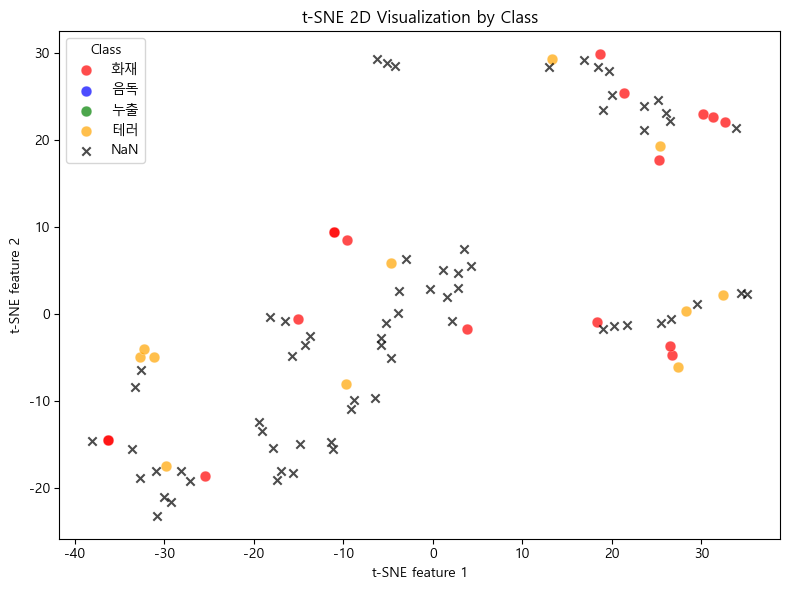

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# — 1) 클래스별 색 지정 —
label_colors = {
    '화재': 'red',
    '음독': 'blue',
    '누출': 'green',
    '테러': 'orange'
}
nan_color = 'black'  # NaN 용 색

# — 2) test DataFrame 과 X_tsne 의 인덱스 정렬 확인 —
#    이미 df_removed_features 에서 reset_index(drop=True) 했다고 가정
#    test = df.loc[idx, :].reset_index(drop=True)
#    X_tsne 의 순서도 이 reset된 순서와 일치해야 합니다.

# — 3) Plot —
fig, ax = plt.subplots(figsize=(8, 6))

# (a) 정상 클래스 4종
for cls, color in label_colors.items():
    mask = test['class'] == cls
    idxs = np.where(mask)[0]
    ax.scatter(
        X_tsne[idxs, 0],
        X_tsne[idxs, 1],
        c=color,
        label=cls,
        alpha=0.7,
        edgecolors='w',  # optional: 점 테두리 흰색
        linewidths=0.3,
        s = 60
    )

# (b) NaN 클래스
mask_nan = test['class'].isna()
idxs_nan = np.where(mask_nan)[0]
if len(idxs_nan):
    ax.scatter(
        X_tsne[idxs_nan, 0],
        X_tsne[idxs_nan, 1],
        c=nan_color,
        label='NaN',
        alpha=0.7,
        marker='x'      # optional: NaN은 x 마커로
    )

# — 4) 꾸미기 —
ax.set_title('t-SNE 2D Visualization by Class')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.legend(title='Class', loc='best', frameon=True)
plt.tight_layout()
plt.show()


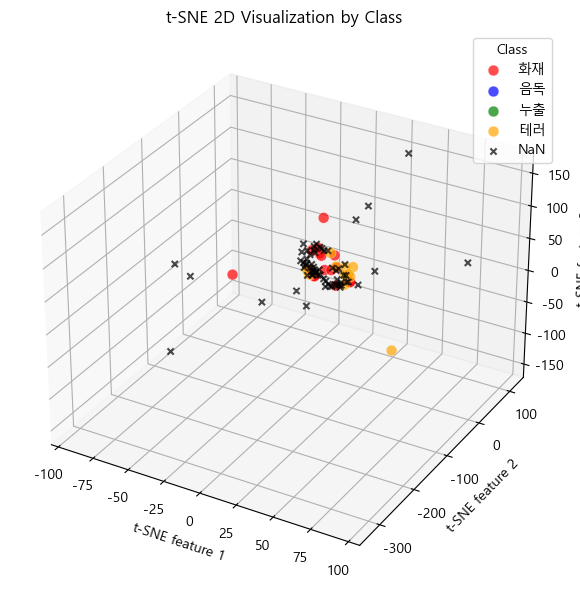

In [107]:
X_tsne3D = tsne3D.fit_transform(X)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# — 1) 클래스별 색 지정 —
label_colors = {
    '화재': 'red',
    '음독': 'blue',
    '누출': 'green',
    '테러': 'orange'
}
nan_color = 'black'  # NaN 용 색

# — 2) test DataFrame 과 X_tsne 의 인덱스 정렬 확인 —
#    이미 df_removed_features 에서 reset_index(drop=True) 했다고 가정
#    test = df.loc[idx, :].reset_index(drop=True)
#    X_tsne 의 순서도 이 reset된 순서와 일치해야 합니다.

# — 3) Plot —
fig, ax = plt.subplots(
    figsize=(8,6),
    subplot_kw={'projection': '3d'}  # 3D 축 생성
)
# (a) 정상 클래스 4종
for cls, color in label_colors.items():
    mask = test['class'] == cls
    idxs = np.where(mask)[0]
    ax.scatter(
        X_tsne3D[idxs, 0],
        X_tsne3D[idxs, 1],
        X_tsne3D[idxs, 2],
        c=color,
        label=cls,
        alpha=0.7,
        edgecolors='w',  # optional: 점 테두리 흰색
        linewidths=0.3,
        s = 60
    )

# (b) NaN 클래스
mask_nan = test['class'].isna()
idxs_nan = np.where(mask_nan)[0]
if len(idxs_nan):
    ax.scatter(
        X_tsne3D[idxs_nan, 0],
        X_tsne3D[idxs_nan, 1],
        X_tsne3D[idxs_nan, 2],
        c=nan_color,
        label='NaN',
        alpha=0.7,
        marker='x'      # optional: NaN은 x 마커로
    )

# — 4) 꾸미기 —
ax.set_title('t-SNE 2D Visualization by Class')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.set_zlabel('t-SNE feature 3')
ax.legend(title='Class', loc='best', frameon=True)
plt.tight_layout()
plt.show()


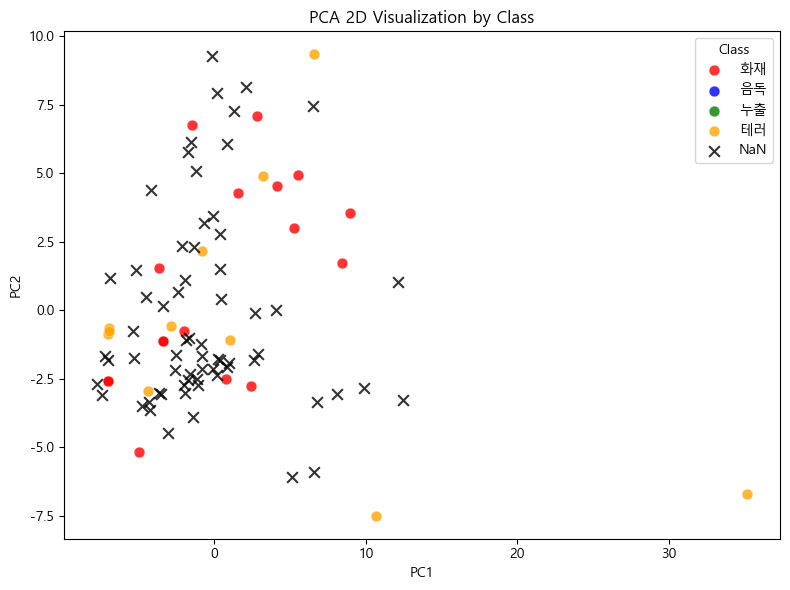

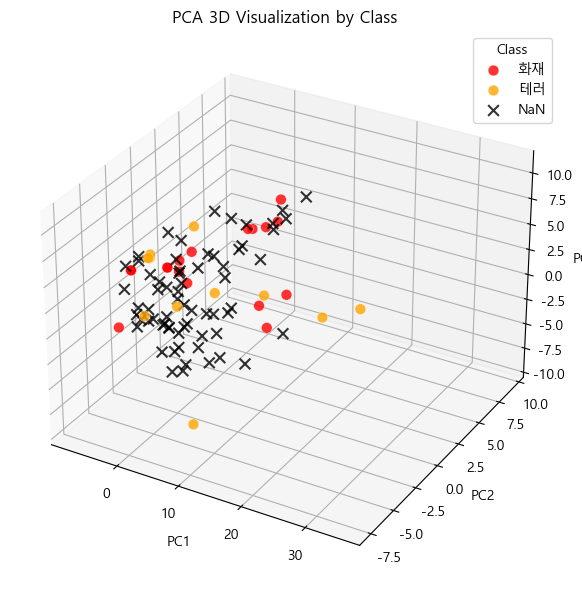

In [108]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# — 0) PCA 모델과 스케일러 정의 및 변환 —
PCA_model2D = PCA(n_components=2)
PCA_model3D = PCA(n_components=3)
scaler     = StandardScaler()

X_scaled   = scaler.fit_transform(X)           # X: (n_samples, n_features)
X_pca2D    = PCA_model2D.fit_transform(X_scaled)
X_pca3D    = PCA_model3D.fit_transform(X_scaled)

# — 1) 클래스별 색 지정 —
label_colors = {
    '화재': 'red',
    '음독': 'blue',
    '누출': 'green',
    '테러': 'orange'
}
nan_color = 'black'

# — 2) 2D Plot —
fig, ax = plt.subplots(figsize=(8,6))
for cls, color in label_colors.items():
    idxs = np.where(test['class']==cls)[0]
    ax.scatter(
        X_pca2D[idxs, 0],
        X_pca2D[idxs, 1],
        c=color,
        label=cls,
        s=60,
        alpha=0.8,
        edgecolors='w',
        linewidths=0.3
    )
# NaN
idxs_nan = np.where(test['class'].isna())[0]
if len(idxs_nan):
    ax.scatter(
        X_pca2D[idxs_nan, 0],
        X_pca2D[idxs_nan, 1],
        c=nan_color,
        label='NaN',
        s=60,
        alpha=0.8,
        marker='x'
    )

ax.set_title('PCA 2D Visualization by Class')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(title='Class', loc='best')
plt.tight_layout()
plt.show()


# — 3) 3D Plot —
from mpl_toolkits.mplot3d import Axes3D  # 필요시 불러오기

fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection='3d')

for cls, color in label_colors.items():
    idxs = np.where(test['class']==cls)[0]
    if len(idxs)==0: 
        continue
    ax.scatter(
        X_pca3D[idxs, 0],
        X_pca3D[idxs, 1],
        X_pca3D[idxs, 2],
        c=color,
        label=cls,
        s=60,
        alpha=0.8,
        edgecolors='w',
        linewidths=0.3
    )
# NaN
if len(idxs_nan):
    ax.scatter(
        X_pca3D[idxs_nan, 0],
        X_pca3D[idxs_nan, 1],
        X_pca3D[idxs_nan, 2],
        c=nan_color,
        label='NaN',
        s=60,
        alpha=0.8,
        marker='x'
    )

ax.set_title('PCA 3D Visualization by Class')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(title='Class', loc='best')
plt.tight_layout()
plt.show()
